## Introdução:
- Etapa de processamento e organização dos dados de sono dos pacientes por meio do algoritmo Cole-Kripke
- O algoritmo Cole-Kripke utiliza o valor da atividade para calcular se o minuto atual é de vigília ou sono:
    - label = 0 indica sono;
    - label = 1 indica vigília;

# Codificação

## Import of libs

In [24]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from tabulate import tabulate
from datetime import datetime
from typing import List, Union

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

### Obs

### * User_1 * shows two sleep phases because the subject woke up for an extended amount of time 
  (more than 40 minutes) during the night, resulting in two independent sleep periods.
### * User_7 * did not fill in the STAI-Y 2 questionnaire.
### * User_11 * does not have sleep data due to technical problems with data recording.
### * User_18 * did not provide his age data.
### * User_21 * did not provide salivary samples of sufficient quality to assess hormone levels.

### users_missing_data = ['user_7', 'user_11', 'user_18', 'user_21']

### * [user_8, user_9] * precisou de uma mudança na informação contida na coluna 'day', do aquivo de 'Actigraphy.csv', corrigindo de -29 para 2.



## Funções

### Tratamento das datas

In [11]:
def merge_dfs(df_acty : pd.DataFrame, df_actigraphy : pd.DataFrame) -> pd.DataFrame:
    """
        Merge the dfs actigraphy with activity.

        Args:
            df_acty : dados de atividades
            df_actigraphy : dados de actigrafia
    """
    format_date = "%H:%M:%S"
    df_actigraphy['time'] = pd.to_datetime(df_actigraphy['time'], exact=True, cache=True, format=format_date).dt.time

    format_date = "%H:%M"
    df_acty['Start'] = pd.to_datetime(df_acty['Start'], exact=True, cache=True, format=format_date).dt.time
    df_acty['End'] = pd.to_datetime(df_acty['End'], exact=True, cache=True, format=format_date).dt.time
  
    for row in range(df_acty.shape[0]):      
        df_actigraphy.loc[(df_actigraphy['time'] >= df_acty.at[row, 'Start']) 
                        & (df_actigraphy['time'] <= df_acty.at[row, 'End'])
                        & (df_actigraphy['day'] == df_acty.at[row, 'Day']), 'Activity'] = df_activity.at[row, 'Activity']
    return df_actigraphy    

### Transformar as amostras em Minutos

In [12]:
def reorder_df_to_minuts(df : pd.DataFrame = None) -> pd.DataFrame:
    '''
        Funcao para encontrar a media do vetor de magnitude em cada minuto
        Args:
            df -> recebe uma copia de um dataframe
    '''
    if df is not None:
        df['datetime'] = pd.to_datetime(df['day'].astype(str) + ' ' + df['time'], format='%d %H:%M:%S')
        df['minute'] = df['datetime'].dt.floor('min')
        df_mean_vm_per_minute = df.groupby('minute')['Vector Magnitude'].mean().reset_index()
    return df_mean_vm_per_minute

def reorder_df_to_minutes_max(df : pd.DataFrame = None) -> Union[pd.DataFrame, None]:
    '''
        Funcao para encontrar a media do vetor de magnitude em cada minuto
        Args:
            df -> recebe uma copia de um dataframe
    '''
    ###############
    # Preparo do dataframe
    # start
    
    # Gerar uma nova coluna com a juncao das colunas de dia e minutos do dataframe do tipo Datetime
    df['datetime'] = pd.to_datetime(df['day'].astype(str) + ' ' + df['time'].astype(str), format='%d %H:%M:%S', )
    # Seta o indice do df como Datetime para manipulacao futura e dropa uma coluna desnecessaria, caso exista
    df.set_index('datetime', inplace=True)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    # end
    ###############
    
    ###############
    # Janelamento: A partir de uma janela de tempo predefinida atribuida em 'janela', definindo a janela e a sobreposição em segundos
    # start
    
    janela = '10s'  # 10 segundos
    sobreposicao = pd.to_timedelta(janela) - '4s'  # 4 segundos
    
    # anota os resultados, ponto de inicio da coleta e anota o numero de epocas (uma epoca == comprimento do segmento)
    results = []
    start = df.index[0]
    epoca = 0

    print('Inicio de janelamento...')
    # inicio do janemento
    while start < df.index[-1]:
        end = start + pd.to_timedelta(janela)
    
        # seleciona o intevalo que contem dados
        window_info = df[(df.index >= start) & (df.index < end)]
    
        if not window_info.empty:
            epoca += 1
            result = window_info[['Vector Magnitude']].idxmax() # capta o indice com maior valor de 'Vetor de Magnitude'
            results.append((result.item(), epoca))              # retorna apenas o valor em tempo (Datetime) e epoca
            
            # print("Inicio: {}; Fim: {}".format(start, end))
    
        # avanca conforme a sobreposicao estabelecida
        start = start + pd.to_timedelta(sobreposicao) 

    print('Fim de janelamento...')
    # gera um novo dataframe com a observação em 'n' segundoso
    df_sub = pd.DataFrame(results, columns=['datetime', 'epoca'])
    df_sub.set_index('datetime', inplace=True)

    print('Merger de sub amostras com o dataframe principal, saindo do formato: {0}'.format(df.shape))
    # junta o dataframe df_10s ao primeiro com o método inner
    df = df.merge(df_sub, left_index=True, right_index=True, how='inner')
    print('... para o formato: {0}'.format(df.shape))
    
    # adiciona uma coluna de contole datetime_floor para arredondar o datetime indicado no index para o minuto pertencente
    df['daytime_floor'] = df.index.floor('min')
    
    # end
    ##############

    ###############
    # Janelamento: 
    # Repete a operacao feita em no contexto de segundos, dessa vez em minutos
    # start

    print('Transformando em minutos.')
    minute_by_minute = df['daytime_floor'].min()
    limite_max = df['daytime_floor'].max()

    
    results = []
    while minute_by_minute < (limite_max):
        # para o caso do minuto observado nao existir na coleta
        try:
            res = df[df['daytime_floor'] == minute_by_minute]['Vector Magnitude'].idxmax()
            results.append(res)
            minute_by_minute += pd.to_timedelta('1min')
        except:
            minute_by_minute += pd.to_timedelta('1min')
            # print("min: {0}; max: {1}; minute_by_minute: {2}".format(minute_by_minute, limite_max, minute_by_minute))

    # Remove possiveis duplicacoes segundo o subconjunto selecionado
    df = df.loc[results].drop_duplicates(keep='last', subset=['Axis1','Axis2','Axis3','daytime_floor'])
    print("Formato final: {0}".format(df.shape))
    print('Fim.')
    
    # end
    ##############
    
    return df.reset_index()

### Algoritmo Cole-Kripke

In [13]:
def create_colekripke_label(df : pd.DataFrame = None) -> pd.DataFrame:
    '''
        Calculo do VM em minutos -> A_(n) = np.sqrt(ax*ax + ay*ay + az*az)
        Cole-Cripke : D = 0.00001*(404*A_(-4) + 598*A_(-3) + 326*A_(-2) + 441*A_(-1) + 1408*(A_(0)) + 508*A_(1) + 350*A_(2))

        Resultados do alg. Cole-Kripke: label = 0 indica que a pessoa esteja dormindo; 
                                        label = 1 indica que a pessoa esteja acordada; 
        Plus:
            Fórmula para calculo do Vetor de Magnitude:
                np.sqrt(ax*ax + ay*ay + az*az)
    '''
    
    tempo_anter_4 = 4
    tempo_anter_3 = 3
    tempo_anter_2 = 2
    tempo_anter_1 = 1
    tempo_atual_0 = 0
    tempo_poste_1 = 1
    tempo_poste_2 = 2
    wheights = [404,598,326,441,1408,508,350]

    array_colekripke = np.zeros(df.shape[0])
    array_labels = np.zeros(df.shape[0])
    
    for index_at in range(tempo_anter_4, df.shape[0]-tempo_poste_2, 1):
        colekripke = 0.00001*(wheights[0]*(df.at[index_at-tempo_anter_4, "Vector Magnitude"] if index_at-tempo_anter_4 >=0 else 0.0) + \
                              wheights[1]*(df.at[index_at-tempo_anter_3, "Vector Magnitude"] if index_at-tempo_anter_3 >=0 else 0.0) + \
                              wheights[2]*(df.at[index_at-tempo_anter_2, "Vector Magnitude"] if index_at-tempo_anter_2 >=0 else 0.0) + \
                              wheights[3]*(df.at[index_at-tempo_anter_1, "Vector Magnitude"] if index_at-tempo_anter_1 >=0 else 0.0) + \
                              wheights[4]*(df.at[index_at-tempo_atual_0, "Vector Magnitude"] if index_at-tempo_atual_0 >=0 else 0.0) + \
                              wheights[5]*(df.at[index_at-tempo_poste_1, "Vector Magnitude"] if index_at-tempo_poste_1 >=0 else 0.0) + \
                              wheights[6]*(df.at[index_at-tempo_poste_2, "Vector Magnitude"] if index_at-tempo_poste_2 >=0 else 0.0))
        
        array_colekripke[index_at] = colekripke

        # label: 1 [acordado]
        # label: 0 [dormindo]
        array_labels[index_at] = 1 if colekripke >= 1 else 0
    
    df = df.assign(colekripke=array_colekripke)    
    df = df.assign(label=array_labels)
    return df.iloc[tempo_anter_4:-1*tempo_poste_2, :].reset_index()

### Funcoes com as Regras de Cole Kripke

In [14]:
def regra_a(df):
    """
        Após pelo menos 4 minutos identificados como vigilia, o próximo minuto identificado como sono é reavaliado como vigilia;

        Args: 
            df : uma copia do dataframe a ser tratado
    """
    salto = 4
    limit_end = salto
    rotulo_alvo = salto

    labels = df["label"].values.copy()
    aplicou_regra = df["label"].values.copy()
    
    janela_vigilia = [1,1,1,1]
    limit_loop = len(labels)
    idx = 0
    
    while(idx < limit_loop and limit_end < limit_loop):
        # verifica se na janela contém apensa vigilia [0,0,0,0]
        # caso True: olha o elemento adjancente e salta até o adjacente
        # caso False: segue o barco. Salta de um em um minuto
        if list(labels[idx:limit_end]) == janela_vigilia \
        and labels[limit_end] == 0:    
            idx += salto
            aplicou_regra[limit_end] = 1
            
        idx += 1
        limit_end = idx + salto # elemento adjacente a direita
        
    df["Regra_A"] = aplicou_regra
    return df

def regra_b(df):
    """
        Após pelo menos 10 minutos identificados como vigília, os próximos 3 minutos identificados como sono são reavaliados como vigília.
    
        Args: 
            df : uma copia do dataframe a ser tratado
    """
    df = df.copy()
    aplicou_regra = df["Regra_A"].values.copy()
    labels = df["Regra_A"].values.copy()
    
    idx = 10
    while idx < len(labels) - 3:
        if all(labels[idx - 10:idx] == 1) \
        and all(labels[idx:idx + 3] == 0):
            
            aplicou_regra[idx:idx + 3] = 1  # Marca que a regra foi aplicada nesses minutos
            idx += 3  # Pula os próximos 3 minutos já reclassificados
            
        idx += 1 # Pula um elemento para iniciar de uma janela totalmente nova

    df["Regra_B"] = aplicou_regra
    return df

def regra_c(df):
    """
        Após pelo menos 15 minutos identificados como vigília, os próximos 4 minutos identificados como sono são reavaliados como vigília.     
        Args:
            df : uma copia do dataframe a ser tratado
    """
    aplicou_regra = df["Regra_B"].values.copy()
    labels = df["Regra_B"].values.copy()
    
    idx = 15
    while idx < len(labels) - 4:
        if all(labels[idx - 15:idx] == 1) \
        and all(labels[idx:idx + 4] == 0):

            aplicou_regra[idx:idx + 4] = 1  # Marca que a regra foi aplicada nesses minutos
            idx += 4  # Pula os próximos 3 minutos já reclassificados
            
        idx += 1 # Pula um elemento para iniciar de uma janela totalmente nova

    df["Regra_C"] = aplicou_regra
    return df

def regra_d(df):
    """
        Se 6 minutos ou menos forem identificados como sono e estiverem cercados por pelo menos 10 minutos (antes e depois) 
        identificados como vigília, esses 6 minutos são reavaliados como vigília.
            
        Args: 
            df : uma copia do dataframe a ser tratado
    """
    aplicou_regra = df["Regra_C"].values.copy()
    labels = df["Regra_C"].values.copy()

    i = 10
    while i < len(labels) - 10:
        if all(labels[i - 10:i] == 1):
            # Verificar sequência de sono de até 6 minutos
            sleep_duration = 0
            j = i
            while j < len(labels) and labels[j] == 0 and sleep_duration < 6:
                sleep_duration += 1
                j += 1

            if sleep_duration <= 6 and all(labels[j:j + 10] == 1):
                aplicou_regra[i:j] = 1  # Marca que a regra foi aplicada
                i = j + 10  # Pula os minutos já verificados
        i += 1

    df["Regra_D"] = aplicou_regra
    return df

def regra_e(df):
    """
        Se 10 minutos ou menos forem identificados como sono e estiverem cercados por pelo menos 20 minutos (antes e depois) 
        identificados como vigília, esses 10 minutos são reavaliados como vigília.
        Args: 
            df : uma copia do dataframe a ser tratado
    """
    aplicou_regra = df["Regra_D"].values.copy()
    labels = df["Regra_D"].values.copy()

    i = 20
    while i < len(labels) - 20:
        if all(labels[i - 20:i] == 1):
            # Verificar sequência de sono de até 10 minutos
            sleep_duration = 0
            j = i
            while j < len(labels) and labels[j] == 0 and sleep_duration < 10:
                sleep_duration += 1
                j += 1

            if sleep_duration <= 10 and all(labels[j:j + 20] == 1):
                aplicou_regra[i:j] = 1  # Marca que a regra foi aplicada
                i = j + 20  # Pula os minutos já verificados
        i += 1

    df["Regra_E"] = aplicou_regra
    return df

### Anexar as informações do actigraphy aos labels criados na funcao create_colekripke_label

In [15]:
def merge_actigraphy_labels(df_actigraphy : pd.DataFrame, df_labels : pd.DataFrame) -> pd.DataFrame:
    """
        Merge the dfs actigraphy with Cole Kripkes' labels algorithm.

        Args:
            df_actigraphy : dados de actigrafia
            df_labels : dados de atividades
    """
    # Cria o dia+tempo+hora e arredonda com o day_minute
    df_actigraphy['day_minute'] = pd.to_datetime(df_actigraphy['day'].astype(str) + ' ' + df_actigraphy['time'], format='%d %H:%M:%S')
    df_actigraphy['datetime'] = df_actigraphy['day_minute'].dt.floor('min')
    df_labels['datetime'] = df_labels['datetime'].dt.floor('min')

    # remove a coluna de dia e tempo
    df_actigraphy.drop(columns=['day', 'time', 'day_minute'], axis=1, inplace=True)

    # adiciona os campos pela 
    result = pd.merge(df_actigraphy, df_labels[['datetime','colekripke', 'label']], how='left', on='datetime')
    result.drop(columns=['Unnamed: 0'], inplace=True)

    # Remove possiveis valores Nan devido o salto de 4min iniciais e 2min finais
    result.dropna(inplace=True)
    
    return result

### Cálculo das métricas para o período de adormecimento

In [16]:
def calculate_sleep_metrics_with_max_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Seguindo o artigo de Cole-Kripke: O critério de início de sono foi escolhido após testes em 4 voluntários.
        O candidato adotou o conceito de 'início do sono', que é o começo do primeiro intervalo contendo pelo menos 1 minuto classificado 
    como estágio 1 do sono ou superior, com no máximo 1 minuto de vigília interveniente". Os mesmos critérios foram aplicados tanto aos 
    registros de PSG quanto de actigrafia. Os valores de n testados foram 1, 10, 15 e 20. 
    
        O critério de 20 minutos mostrou a maior correlação entre as pontuações de PSG e actigrafia (Tabela 4) e, por isso, 
    foi utilizado em todas as análises posteriores nas amostras de treinamento e validação (Tabela 5). 
    É interessante notar, no entanto, que o critério de actigrafia de 20 minutos também se correlacionou fortemente com o critério de 
    PSG de 15 minutos (treinamento: r = 0,91, validação: r = 0,90). 
    
        Além disso, em ambas as amostras de treinamento e validação, a latência média do sono pelo critério de actigrafia de 20 minutos 
    foi cerca de 2 minutos mais próxima da latência média do sono pelo critério de PSG de 15 minutos do que da latência média do sono 
    pelo critério de PSG de 20 minutos.
    
    Args:
        df: DataFrame contendo as colunas 'datetime', 'label' e 'Vector Magnitude'.

    Retorna:
        DataFrame com as métricas de sono no formato especificado.
    """
    sleep_metrics = []
    in_bed = True
    sleep_onset = None
    bed_start_time = None
    bed_end_time = None
    total_minutes_in_bed = 0
    total_sleep_time = 0
    waso = 0
    awakenings = 0
    movement_index = 0
    sleep_fragments = 0
    consecutive_sleep = 0
    consecutive_wake = 0
    tempo_observacao = 20
    majoritary_vote = 3
    aux_idx = 0
    zero_true = True
    latency = None
    len_df = df.shape[0]
    ciclo = 0

    # Inicializa duas novas colunas de controle para acompanhar o tempo em que a pessoa esteve acordado, e 
    # o tempo em que a pessoa este dormindo.
    df.loc[:, 'consecutive_wake'] = df.loc[:, 'consecutive_sleep'] = [0]*len_df
    
    for i in range(1, len_df - 1):
        # Variavel de controle para sono e despestar
        if df.at[i, 'label'] == 0:
            consecutive_sleep = (consecutive_sleep + 1) if consecutive_sleep < tempo_observacao else tempo_observacao
            consecutive_wake  = (consecutive_wake - 1) if consecutive_wake > 0 else 0
        else:
            consecutive_sleep = (consecutive_sleep - 1) if consecutive_sleep > 0 else 0
            consecutive_wake = (consecutive_wake + 1) if consecutive_wake < tempo_observacao else tempo_observacao

        df.loc[i,'consecutive_sleep'] = consecutive_sleep
        df.loc[i,'consecutive_wake']  = consecutive_wake
        
        #Debug
        # print('c_sleep: {0} - c_wake: {1} - sstart: {2} - satual: {3} - lb_start: {4} - lb_atual: {5}'\
        #       .format(consecutive_sleep,
        #              consecutive_wake,
        #              df.at[i-(consecutive_sleep-1), 'daytime_floor'], 
        #              df.at[i, 'daytime_floor'],
        #              df.at[i-(consecutive_sleep-1), 'label'],
        #              df.at[i, 'label'])
        #      )
        #Debug
        
        # Garante olhar dados anteriores a (i - consecutive_sleep)
        if (i - consecutive_sleep) > 0:
               
            # Detecta o início de sono apos a variavel 'tempo_observacao' em minutos consecutivos de label == 0
            if (df.at[i-(consecutive_sleep-1), 'label'] == df.at[i, 'label']) \
                and (df.at[i, 'label'] == 0) \
                and (consecutive_sleep == tempo_observacao) \
                and (in_bed):

                # Primeira verificacao de pesquisa o ponto inicial do sono do individuo
                # ate registrar df.at[aux_idx, 'consecutive_sleep'] == 1
                aux_idx = i
                while df.at[aux_idx, 'consecutive_sleep'] != 0:
                    sleep_onset = df.at[aux_idx, 'daytime_floor']  # Inicio do sono a consecutivos minutos antes
                    aux_idx -= 1

                # Segunda verificacao para identificacao do momento inicial do sono, pulando alguns registros voluntarios.
                if bed_end_time is None:
                    while 1 \
                    and (aux_idx - tempo_observacao) > 0:
                        if df.loc[aux_idx-tempo_observacao:aux_idx, 'consecutive_sleep'].sum() == 0:
                            aux_idx += 1
                            bed_start_time = df.at[aux_idx, 'daytime_floor']
                            break
                        else:
                            # Varifica a partir do inicio da janela, ou tempo mais distante dentro da janela de observacao 
                            aux_idx = aux_idx-tempo_observacao
                            while df.at[aux_idx, 'consecutive_sleep'] == 0:
                                aux_idx += 1
                            else:
                                bed_start_time = df.at[aux_idx, 'daytime_floor']
                        aux_idx -= 1
                else:
                    while 1 \
                    and (aux_idx - tempo_observacao) > 0 \
                    and df.at[aux_idx-tempo_observacao, 'daytime_floor'] > bed_end_time:
                        if df.loc[aux_idx-tempo_observacao:aux_idx, 'consecutive_sleep'].sum() == 0:
                            aux_idx += 1
                            bed_start_time = df.at[aux_idx, 'daytime_floor']
                            break
                        else:
                            # Varifica a partir do inicio da janela, ou tempo mais distante dentro da janela de observacao 
                            aux_idx = aux_idx-tempo_observacao
                            while df.at[aux_idx, 'consecutive_sleep'] == 0:
                                aux_idx += 1
                            else:
                                bed_start_time = df.at[aux_idx, 'daytime_floor']
                        aux_idx -= 1                       
                
                # print(f'start: {bed_start_time}')
                latency = (sleep_onset - bed_start_time).seconds / 60
                in_bed = False # var de controle
            
            # Detecta o final do ciclo de sono (sair da cama) em minutos consecutivos de label == 1 
            # Prep. 0: caso chegue ao fim do dataframe e o status for [0] e nao tenha sido anotado nenhum ciclo de sono
            if (i == len_df - 2) \
                and (not in_bed) \
                and ciclo == 0:
                # ate registrar df.at[aux_idx, 'consecutive_sleep'] == 0        
                bed_end_time = df.at[i-(consecutive_wake-1), 'daytime_floor'] = df.at[i, 'daytime_floor']  # Inicio do sono a consecutivos minutos antes
            
                # Calcula o tempo total na cama
                total_minutes_in_bed = (bed_end_time - bed_start_time).seconds / 60

                if total_minutes_in_bed <= tempo_observacao:
                    in_bed = False
                    continue
                
                # Calcula o Total Sleep Time (TST)
                total_sleep_time = df[(df['daytime_floor'] >= bed_start_time) \
                                      & (df['daytime_floor'] <= bed_end_time) \
                                      & (df['label'] == 0)].shape[0]
    
                # Calcula o WASO (Wake After Sleep Onset)
                waso = df[(df['daytime_floor'] > sleep_onset) \
                          & (df['daytime_floor'] <= bed_end_time) \
                          & (df['label'] == 1)].shape[0]                
    
                # Eficiência do sono
                efficiency = (total_sleep_time / total_minutes_in_bed) * 100


                # Índice de Movimento (média do Vector Magnitude durante o sono)
                df_moviment = df[(df['datetime'] >= bed_start_time) & (df['datetime'] <= bed_end_time)]
                movement_index = (df_moviment[df_moviment.label == 1]['label'].count() / df_moviment.label.count()) * 100

            
                # Calcula o número de despertares (transição de sono para vigília)
                awakenings = ((df_moviment['label'].shift(-1) == 0) \
                              & (df_moviment['label'] == 1)).sum()
            
                # Calcula a duração média dos despertares
                avg_awakening_length = waso / awakenings if awakenings > 0 else 0
                
                # df_sub = df[(df['daytime_floor'] >= bed_start_time) & (df['daytime_floor'] <= bed_end_time)].reset_index()
                # if df_sub.shape[0] > 2:
                #     for j in range(1, df_sub.shape[0]):
                #         if df_sub.at[j-1, 'consecutive_wake'] == 0 \
                #         and df_sub.at[j, 'consecutive_wake'] == 1:
                #             awakenings += 1
                # else:
                #     awakenings = 1

                # Índice de Fragmentação (número de fragmentos de sono curtos)
                sleep_fragments = (df_moviment[df_moviment.label == 0]['label'].count() / df_moviment.label.count()) * 100

                # Adiciona os dados calculados ao DataFrame
                sleep_metrics.append({
                    'In Bed Date': bed_start_time.date(),
                    'In Bed Time': bed_start_time.time(),
                    'Out Bed Date': bed_end_time.date(),
                    'Out Bed Time': bed_end_time.time(),
                    'Onset Date': sleep_onset.date(),
                    'Onset Time': sleep_onset.time(),
                    'Latency': latency,  # Latência é 0 para simplificação
                    'Efficiency': efficiency,
                    'Total Minutes in Bed': total_minutes_in_bed,
                    'Total Sleep Time (TST)': total_sleep_time,
                    'Wake After Sleep Onset (WASO)': waso,
                    'Number of Awakenings': awakenings,
                    'Average Awakening Length': avg_awakening_length,
                    'Movement Index': movement_index,
                    'Fragmentation Index': sleep_fragments,
                    'Sleep Fragmentation Index': movement_index / sleep_fragments if sleep_fragments > 0 else movement_index
                })
                # print(f'end: {bed_end_time}; total_minutes_in_bed: {total_minutes_in_bed}')
                in_bed = True # var de controle

            # Prep. 1: checa se o label atual corresponde com o label visto há 'consecutive_wake' minutos passados
            # Prep. 2: o label atual corresponde ao estado de acordado (wake == 1)
            # Prep. 3: checa se o tempo observado corresponde ao tempo de observacao
            # Prep. 4: nao esta na cama
            elif (df.at[i-(consecutive_wake - 1), 'label'] == df.at[i, 'label']) \
                and (df.at[i, 'label'] == 1) \
                and (consecutive_wake == tempo_observacao) \
                and (not in_bed):
                
                # ate registrar df.at[aux_idx, 'consecutive_sleep'] == 1
                aux_idx = i
                while df.at[aux_idx, 'consecutive_wake'] != 0:
                    bed_end_time = df.at[i-(consecutive_wake-1), 'daytime_floor'] = df.at[aux_idx, 'daytime_floor']  # Inicio do sono a consecutivos minutos antes
                    aux_idx -= 1            
            
                # Calcula o tempo total na cama
                total_minutes_in_bed = (bed_end_time - bed_start_time).seconds / 60

                if total_minutes_in_bed <= tempo_observacao:
                    in_bed = False
                    continue
                
                # Calcula o Total Sleep Time (TST)
                total_sleep_time = df[(df['daytime_floor'] >= bed_start_time) \
                                      & (df['daytime_floor'] <= bed_end_time) \
                                      & (df['label'] == 0)].shape[0]
    
                # Calcula o WASO (Wake After Sleep Onset)
                waso = df[(df['daytime_floor'] > sleep_onset) \
                          & (df['daytime_floor'] <= bed_end_time) \
                          & (df['label'] == 1)].shape[0]                
    
                # Eficiência do sono
                efficiency = (total_sleep_time / total_minutes_in_bed) * 100


                # Índice de Movimento (média do Vector Magnitude durante o sono)
                df_moviment = df[(df['datetime'] >= bed_start_time) & (df['datetime'] <= bed_end_time)]
                movement_index = (df_moviment[df_moviment.label == 1]['label'].count() / df_moviment.label.count()) * 100

            
                # Calcula o número de despertares (transição de sono para vigília)
                awakenings = ((df_moviment['label'].shift(-1) == 0) \
                              & (df_moviment['label'] == 1)).sum()
            
                # Calcula a duração média dos despertares
                avg_awakening_length = waso / awakenings if awakenings > 0 else 0
                
                # df_sub = df[(df['daytime_floor'] >= bed_start_time) & (df['daytime_floor'] <= bed_end_time)].reset_index()
                # if df_sub.shape[0] > 2:
                #     for j in range(1, df_sub.shape[0]):
                #         if df_sub.at[j-1, 'consecutive_wake'] == 0 \
                #         and df_sub.at[j, 'consecutive_wake'] == 1:
                #             awakenings += 1
                # else:
                #     awakenings = 1

                # Índice de Fragmentação (número de fragmentos de sono curtos)
                sleep_fragments = (df_moviment[df_moviment.label == 0]['label'].count() / df_moviment.label.count()) * 100

                # Adiciona os dados calculados ao DataFrame
                sleep_metrics.append({
                    'In Bed Date': bed_start_time.date(),
                    'In Bed Time': bed_start_time.time(),
                    'Out Bed Date': bed_end_time.date(),
                    'Out Bed Time': bed_end_time.time(),
                    'Onset Date': sleep_onset.date(),
                    'Onset Time': sleep_onset.time(),
                    'Latency': latency,  # Latência é 0 para simplificação
                    'Efficiency': efficiency,
                    'Total Minutes in Bed': total_minutes_in_bed,
                    'Total Sleep Time (TST)': total_sleep_time,
                    'Wake After Sleep Onset (WASO)': waso,
                    'Number of Awakenings': awakenings,
                    'Average Awakening Length': avg_awakening_length,
                    'Movement Index': movement_index,
                    'Fragmentation Index': sleep_fragments,
                    'Sleep Fragmentation Index': movement_index / sleep_fragments if sleep_fragments > 0 else movement_index
                })
                # print(f'end: {bed_end_time}; total_minutes_in_bed: {total_minutes_in_bed}')
                in_bed = True # var de controle
                ciclo += 1
            awakenings = 0
                
    # # Retorna o DataFrame com as métricas de sono
    return pd.DataFrame(sleep_metrics)

## Plotar hipnogramas

In [38]:
path_root = "MMASH/DataPaper/"

for user in os.listdir(path_root):

    user = 'user_15'
    path_source = os.path.join(path_root, user, "Actigraph.csv")
    
    print(f'Carregando dados de Actigraph de {path_source}.')
    df_actigraphy = pd.read_csv(path_source)

    print(f'Realizando calculo de vetor de magnitude.')
    df_vetor_mag = reorder_df_to_minutes_max(df_actigraphy.copy())

    print(f'Aplicando algoritmo de Colekripke.')
    df_to_plot = create_colekripke_label(df_vetor_mag.copy())
    break

Carregando dados de Actigraph de MMASH/DataPaper/user_10/Actigraph.csv.
Realizando calculo de vetor de magnitude.
Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (58616, 12)
... para o formato: (12020, 13)
Transformando em minutos.
Formato final: (1222, 14)
Fim.
Aplicando algoritmo de Colekripke.


In [40]:
# df_to_plot

Carregando dados de Actigraph de MMASH/DataPaper/user_10/Actigraph.csv.
Realizando calculo de vetor de magnitude.
Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (58616, 12)
... para o formato: (12020, 13)
Transformando em minutos.
Formato final: (1222, 14)
Fim.
Aplicando algoritmo de Colekripke.


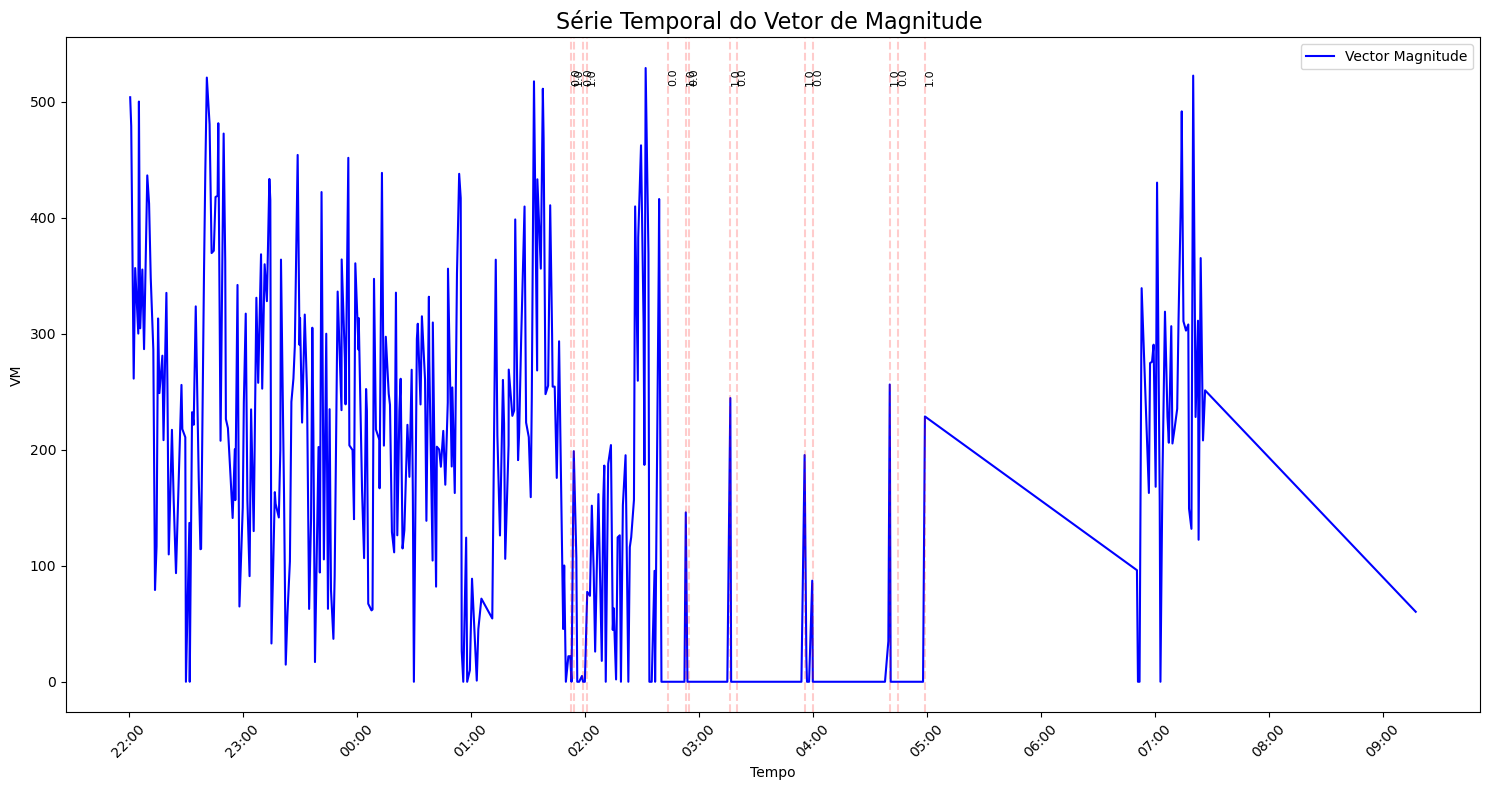

<Figure size 640x480 with 0 Axes>

In [54]:
## Amostra de usuário com classe "boa"

path_root = "MMASH/DataPaper/"

for user in os.listdir(path_root):

    user = 'user_10'
    path_source = os.path.join(path_root, user, "Actigraph.csv")
    
    print(f'Carregando dados de Actigraph de {path_source}.')
    df_actigraphy = pd.read_csv(path_source)

    print(f'Realizando calculo de vetor de magnitude.')
    df_vetor_mag = reorder_df_to_minutes_max(df_actigraphy.copy())

    print(f'Aplicando algoritmo de Colekripke.')
    df_to_plot = create_colekripke_label(df_vetor_mag.copy())
    break

# Create DataFrame
df = df_to_plot.copy()
df = df[df['datetime'] > '1900-01-01 22:00:00']

df['datetime'] = pd.to_datetime(df['datetime'])  # Convert to datetime

# Plotting
plt.figure(figsize=(15, 8))
plt.title('Série Temporal do Vetor de Magnitude ', fontsize=16)

# Plot all fields in one plot
# sns.lineplot(x=df['datetime'], y=df['Axis1'], label='Axis1', color='blue')
# sns.lineplot(x=df['datetime'], y=df['Axis2'], label='Axis2', color='green')
# sns.lineplot(x=df['datetime'], y=df['Axis3'], label='Axis3', color='orange')
sns.lineplot(x=df['datetime'], y=df['Vector Magnitude'], label='Vector Magnitude', color='blue')

# Add annotations for label changes
for j in range(1, len(df)):
    if df['label'].iloc[j] != df['label'].iloc[j - 1]:
        plt.axvline(x=df['datetime'].iloc[j], color='red', linestyle='--', alpha=0.2)
        plt.text(df['datetime'].iloc[j], df['Vector Magnitude'].max(), 
                 f'{df["label"].iloc[j]}', rotation=90, 
                 verticalalignment='top', fontsize=8, color='black')

# Format x-axis to show one tick per hour
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

# Add labels and legend
plt.xlabel('Tempo')
plt.ylabel('VM')
plt.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()
plt.savefig('Sono_Vigilia_User10_boa')

Carregando dados de Actigraph de MMASH/DataPaper/user_11/Actigraph.csv.
Realizando calculo de vetor de magnitude.
Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (68362, 12)
... para o formato: (14066, 13)
Transformando em minutos.
Formato final: (1428, 14)
Fim.
Aplicando algoritmo de Colekripke.


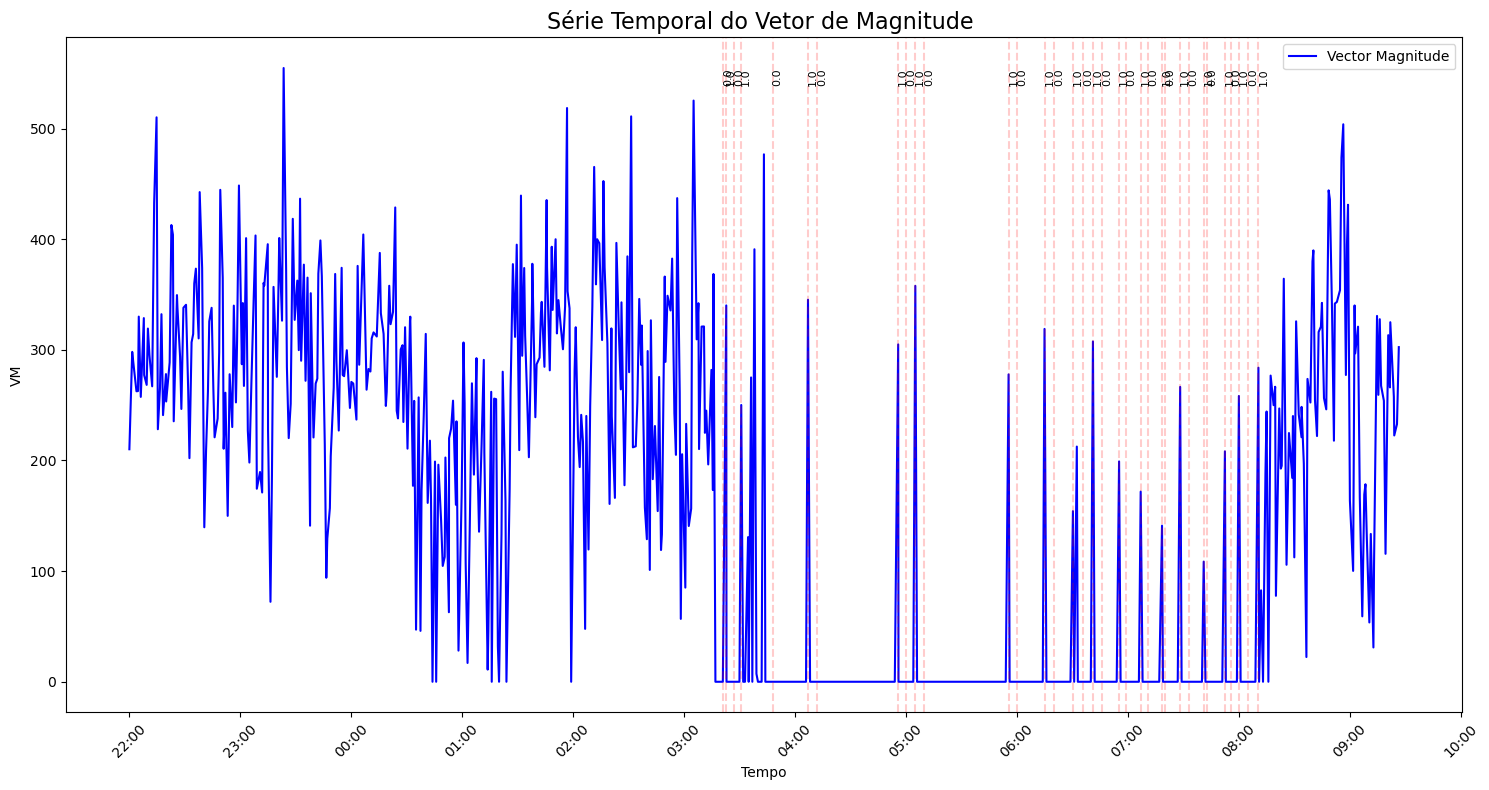

<Figure size 640x480 with 0 Axes>

In [55]:
## Amostra de usuário com classe "ruim"

path_root = "MMASH/DataPaper/"

for user in os.listdir(path_root):

    user = 'user_11'
    path_source = os.path.join(path_root, user, "Actigraph.csv")
    
    print(f'Carregando dados de Actigraph de {path_source}.')
    df_actigraphy = pd.read_csv(path_source)

    print(f'Realizando calculo de vetor de magnitude.')
    df_vetor_mag = reorder_df_to_minutes_max(df_actigraphy.copy())

    print(f'Aplicando algoritmo de Colekripke.')
    df_to_plot = create_colekripke_label(df_vetor_mag.copy())
    break

# Create DataFrame
df = df_to_plot.copy()
df = df[df['datetime'] > '1900-01-01 22:00:00']

df['datetime'] = pd.to_datetime(df['datetime'])  # Convert to datetime

# Plotting
plt.figure(figsize=(15, 8))
plt.title('Série Temporal do Vetor de Magnitude ', fontsize=16)

# Plot all fields in one plot
# sns.lineplot(x=df['datetime'], y=df['Axis1'], label='Axis1', color='blue')
# sns.lineplot(x=df['datetime'], y=df['Axis2'], label='Axis2', color='green')
# sns.lineplot(x=df['datetime'], y=df['Axis3'], label='Axis3', color='orange')
sns.lineplot(x=df['datetime'], y=df['Vector Magnitude'], label='Vector Magnitude', color='blue')

# Add annotations for label changes
for j in range(1, len(df)):
    if df['label'].iloc[j] != df['label'].iloc[j - 1]:
        plt.axvline(x=df['datetime'].iloc[j], color='red', linestyle='--', alpha=0.2)
        plt.text(df['datetime'].iloc[j], df['Vector Magnitude'].max(), 
                 f'{df["label"].iloc[j]}', rotation=90, 
                 verticalalignment='top', fontsize=8, color='black')

# Format x-axis to show one tick per hour
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

# Add labels and legend
plt.xlabel('Tempo')
plt.ylabel('VM')
plt.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()
plt.savefig('Sono_Vigilia_User11_ruim')

## Run All Functions

In [60]:
path_root = "MMASH/DataPaper/"

for user in os.listdir(path_root):
    path_source = os.path.join(path_root, user, "Actigraph.csv")
    
    print(f'Carregando dados de Actigraph de {path_source}.')
    df_actigraphy = pd.read_csv(path_source)

    print(f'Realizando calculo de vetor de magnitude.')
    df_vetor_mag = reorder_df_to_minutes_max(df_actigraphy.copy())

    print(f'Aplicando algoritmo de Colekripke.')
    df_labels = create_colekripke_label(df_vetor_mag.copy())

    print(f'Geração das métricas')
    df_sleep_metrics = calculate_sleep_metrics_with_max_values(df_labels.copy())

    path_target = os.path.join(path_root, user, "sleep_ufam.csv")
    print(f'Salvando {path_target}.')
    df_sleep_metrics.to_csv(path_target, index=False)

    print("############################# \n")
print("Fim do processamento.")

Carregando dados de Actigraph de MMASH/DataPaper/user_19/Actigraph.csv.
Realizando calculo de vetor de magnitude.
Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (68326, 12)
... para o formato: (13985, 13)
Transformando em minutos.
Formato final: (1408, 14)
Fim.
Aplicando algoritmo de Colekripke.
Geração das métricas
Salvando MMASH/DataPaper/user_19/sleep_ufam.csv.
############################# 

Carregando dados de Actigraph de MMASH/DataPaper/user_15/Actigraph.csv.
Realizando calculo de vetor de magnitude.
Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (71045, 12)
... para o formato: (14617, 13)
Transformando em minutos.
Formato final: (1491, 14)
Fim.
Aplicando algoritmo de Colekripke.
Geração das métricas
Salvando MMASH/DataPaper/user_15/sleep_ufam.csv.
############################# 

Carregando dados de Actigraph de MMASH/DataPaper/user_9/Actigrap

In [44]:
# path_root = "MMASH/DataPaper/"

# for user in os.listdir(path_root):
#     path_source = os.path.join(path_root, user, "Actigraph.csv")
    
#     print(f'Carregando dados de Actigraph de {path_source}.')
#     df_actigraphy = pd.read_csv(path_source)

#     print(f'Realizando calculo de vetor de magnitude.')
#     df_vetor_mag = reorder_df_to_minutes_max(df_actigraphy.copy())

#     print(f'Aplicando algoritmo de Colekripke.')
#     df_labels = create_colekripke_label(df_vetor_mag.copy())

#     print(f'Geração das métricas')
#     df_sleep_metrics = calculate_sleep_metrics_with_max_values(df_labels.copy())

#     path_target = os.path.join(path_root, user, "sleep_ufam.csv")
#     print(f'Salvando {path_target}.')
#     df_sleep_metrics.to_csv(path_target, index=False)

#     print("############################# \n")
# print("Fim do processamento.")

Carregando dados de Actigraph de MMASH/DataPaper/user_19/Actigraph.csv.
Realizando calculo de vetor de magnitude.
Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (68326, 12)
... para o formato: (13985, 13)
Transformando em minutos.
Formato final: (1408, 14)
Fim.
Aplicando algoritmo de Colekripke.
Geração das métricas
Salvando MMASH/DataPaper/user_19/sleep_ufam.csv.
############################# 

Carregando dados de Actigraph de MMASH/DataPaper/user_15/Actigraph.csv.
Realizando calculo de vetor de magnitude.
Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (71045, 12)
... para o formato: (14617, 13)
Transformando em minutos.
Formato final: (1491, 14)
Fim.
Aplicando algoritmo de Colekripke.
Geração das métricas
Salvando MMASH/DataPaper/user_15/sleep_ufam.csv.
############################# 

Carregando dados de Actigraph de MMASH/DataPaper/user_9/Actigrap

## Testes e Rascunhos

In [52]:
# Carrega os dados brutos de actigrafia do usuario X
user = "user_15"
data_user = "MMASH/DataPaper/"+user+"/Actigraph.csv"
df_actigraphy = pd.read_csv(data_user)

In [53]:
df_actigraphy[df_actigraphy['day'] == 1]

,Unnamed: 0,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time
0,28,99,32,94,0,207.0,0,1,0,0,140.22,1,09:30:28
1,29,2,54,131,1,207.0,0,0,1,0,141.71,1,09:30:29
2,30,114,95,68,0,207.0,0,1,0,0,163.23,1,09:30:30
3,31,57,30,88,0,207.0,0,1,0,0,109.06,1,09:30:31
4,32,72,105,112,1,207.0,0,1,0,0,169.57,1,09:30:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41310,52195,0,0,0,0,79.0,0,0,1,0,0.00,1,23:59:55
41311,52196,0,0,0,0,79.0,0,0,1,0,0.00,1,23:59:56
41312,52197,0,0,0,0,79.0,0,0,1,0,0.00,1,23:59:57
41313,52198,0,0,0,0,79.0,0,0,1,0,0.00,1,23:59:58


In [27]:
# with pd.option_context('display.max_rows',None,'display.max_columns', None):
#     display(df_actigraphy)

In [54]:
df_vetor_mag = reorder_df_to_minutes_max(df_actigraphy.copy())

Inicio de janelamento...
Fim de janelamento...
Merger de sub amostras com o dataframe principal, saindo do formato: (71045, 12)
... para o formato: (14617, 13)
Transformando em minutos.
Formato final: (1491, 14)
Fim.


In [49]:
df_vetor_mag

,datetime,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,epoca,daytime_floor
0,1900-01-01 09:12:32,82,55,46,1,69.0,0,1,0,0,108.93,1,09:12:32,4,1900-01-01 09:12:00
1,1900-01-01 09:13:58,147,26,153,0,64.0,0,1,0,0,213.76,1,09:13:58,18,1900-01-01 09:13:00
2,1900-01-01 09:14:23,169,82,385,1,73.0,0,1,0,0,428.38,1,09:14:23,23,1900-01-01 09:14:00
3,1900-01-01 09:15:06,67,123,261,1,75.0,0,1,0,0,296.21,1,09:15:06,30,1900-01-01 09:15:00
4,1900-01-01 09:16:38,139,198,234,0,70.0,0,1,0,0,336.57,1,09:16:38,45,1900-01-01 09:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,1900-01-02 08:33:02,87,44,161,1,85.0,0,1,0,0,188.22,2,08:33:02,13805,1900-01-02 08:33:00
1392,1900-01-02 08:34:09,240,65,65,1,76.0,0,1,0,0,257.00,2,08:34:09,13817,1900-01-02 08:34:00
1393,1900-01-02 08:35:13,112,300,96,1,78.0,0,1,0,0,334.31,2,08:35:13,13827,1900-01-02 08:35:00
1394,1900-01-02 08:36:13,35,29,248,1,60.0,0,1,0,0,252.13,2,08:36:13,13837,1900-01-02 08:36:00


In [57]:
df_labels = create_colekripke_label(df_vetor_mag.copy())

with pd.option_context('display.max_rows',None,'display.max_columns', None):
    display(df_labels)

,index,datetime,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,epoca,daytime_floor,colekripke,label
0,4,1900-01-01 09:34:55,57,156,240,0,97.0,0,1,0,0,291.86,1,09:34:55,45,1900-01-01 09:34:00,10.388288,1.0
1,5,1900-01-01 09:35:01,236,76,34,0,99.0,0,1,0,0,250.26,1,09:35:01,46,1900-01-01 09:35:00,9.962333,1.0
2,6,1900-01-01 09:36:15,26,150,173,0,96.0,0,1,0,0,230.45,1,09:36:15,58,1900-01-01 09:36:00,9.533356,1.0
3,7,1900-01-01 09:37:19,213,150,225,1,95.0,0,1,0,0,344.23,1,09:37:19,69,1900-01-01 09:37:00,11.393788,1.0
4,8,1900-01-01 09:38:45,160,164,35,1,96.0,0,1,0,0,231.78,1,09:38:45,83,1900-01-01 09:38:00,10.763716,1.0
5,9,1900-01-01 09:39:20,118,242,94,1,92.0,0,1,0,0,285.17,1,09:39:20,89,1900-01-01 09:39:00,10.930922,1.0
6,10,1900-01-01 09:40:31,43,87,174,1,95.0,0,1,0,0,199.23,1,09:40:31,101,1900-01-01 09:40:00,10.067768,1.0
7,11,1900-01-01 09:41:43,107,31,277,0,98.0,0,1,0,0,298.56,1,09:41:43,113,1900-01-01 09:41:00,10.798900,1.0
8,12,1900-01-01 09:42:16,119,108,138,0,101.0,0,1,0,0,211.82,1,09:42:16,119,1900-01-01 09:42:00,9.804263,1.0
9,13,1900-01-01 09:43:54,131,21,313,0,96.0,0,1,0,0,339.96,1,09:43:54,135,1900-01-01 09:43:00,11.158556,1.0


### Ver a distribuição dos rótulos após aplicação das regras

In [16]:
print("Label sem Regra: {}".format(df_labels.label.value_counts()))

df_labels = regra_a(df_labels.copy())
print("Label Regra_A: {}".format(df_labels.Regra_A.value_counts()))

df_labels = regra_b(df_labels.copy())
print("Label Regra_B: {}".format(df_labels.Regra_B.value_counts()))

df_labels = regra_c(df_labels.copy())
print("Label Regra_C: {}".format(df_labels.Regra_C.value_counts()))

df_labels = regra_d(df_labels.copy())
print("Label Regra_D: {}".format(df_labels.Regra_D.value_counts()))

df_labels = regra_e(df_labels.copy())
print("Label Regra_E: {}".format(df_labels.Regra_E.value_counts()))

Label sem Regra: label
1.0    773
0.0    565
Name: count, dtype: int64
Label Regra_A: Regra_A
1.0    788
0.0    550
Name: count, dtype: int64
Label Regra_B: Regra_B
1.0    809
0.0    529
Name: count, dtype: int64
Label Regra_C: Regra_C
1.0    821
0.0    517
Name: count, dtype: int64
Label Regra_D: Regra_D
1.0    826
0.0    512
Name: count, dtype: int64
Label Regra_E: Regra_E
1.0    828
0.0    510
Name: count, dtype: int64


In [56]:
with pd.option_context('display.max_rows',100,'display.max_columns', None):
    display(df_labels)

,index,datetime,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,epoca,daytime_floor,colekripke,label
0,4,1900-01-01 09:34:55,57,156,240,0,97.0,0,1,0,0,291.86,1,09:34:55,45,1900-01-01 09:34:00,10.388288,1.0
1,5,1900-01-01 09:35:01,236,76,34,0,99.0,0,1,0,0,250.26,1,09:35:01,46,1900-01-01 09:35:00,9.962333,1.0
2,6,1900-01-01 09:36:15,26,150,173,0,96.0,0,1,0,0,230.45,1,09:36:15,58,1900-01-01 09:36:00,9.533356,1.0
3,7,1900-01-01 09:37:19,213,150,225,1,95.0,0,1,0,0,344.23,1,09:37:19,69,1900-01-01 09:37:00,11.393788,1.0
4,8,1900-01-01 09:38:45,160,164,35,1,96.0,0,1,0,0,231.78,1,09:38:45,83,1900-01-01 09:38:00,10.763716,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,1484,1900-01-02 10:51:02,0,0,0,0,152.0,1,0,0,0,0.00,2,10:51:02,14537,1900-01-02 10:51:00,0.000000,0.0
1481,1485,1900-01-02 10:52:08,0,0,0,0,161.0,1,0,0,0,0.00,2,10:52:08,14548,1900-01-02 10:52:00,0.000000,0.0
1482,1486,1900-01-02 10:53:04,0,0,0,0,167.0,1,0,0,0,0.00,2,10:53:04,14558,1900-01-02 10:53:00,0.000000,0.0
1483,1487,1900-01-02 10:54:04,0,0,0,0,148.0,1,0,0,0,0.00,2,10:54:04,14568,1900-01-02 10:54:00,0.000000,0.0


In [ ]:
### Olhar apenas as linhas que sofreram impacto
# cols_toshow = ['Axis1', 'Axis2', 'Axis3', 'datetime', 'label', 'Regra_A', 'Regra_B', 'Regra_C', 'Regra_D', 'Regra_E']
# with pd.option_context('display.max_rows',None,'display.max_columns', None):
#     display(df_labels[(df_labels['label'] != df_labels['Regra_A']) | \
#                (df_labels['label'] != df_labels['Regra_B']) | \
#                (df_labels['label'] != df_labels['Regra_C']) | \
#                (df_labels['label'] != df_labels['Regra_D']) | \
#                (df_labels['label'] != df_labels['Regra_E'])][cols_toshow])

### Nesta etapa vamos igualar os valores contidos no label Regra_E em label

In [ ]:
# df_labels['label_old'] = df_labels['label']
# df_labels['label'] = df_labels['Regra_E']

### Aplicando o calculate metrics e consolidate

In [ ]:
## Looking for a specific span of time
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(df_labels[df_labels['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S').between('1900-01-02 00:43:00', '1900-01-02 05:20:00')])

In [42]:
# Gerar as métricas de sono
df_sleep_metrics = calculate_sleep_metrics_with_max_values(df_labels.copy())

with pd.option_context('display.max_rows',None, 'display.max_columns',None):
    display(df_sleep_metrics)

,In Bed Date,In Bed Time,Out Bed Date,Out Bed Time,Onset Date,Onset Time,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index
0,1900-01-02,00:02:00,1900-01-02,09:20:00,1900-01-02,00:33:00,31.0,89.964158,558.0,502,8,3,2.666667,6.015038,93.984962,0.064


In [ ]:
df_sleep_metrics.to_csv("MMASH/DataPaper/"+user+"/sleep_test.csv", index=False)

In [20]:
data_user_df = "MMASH/DataPaper/"+user+"/sleep.csv"
df_sleep = pd.read_csv(data_user_df)
df_sleep.drop(columns=['Unnamed: 0'],inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_sleep)

,In Bed Date,In Bed Time,Out Bed Date,Out Bed Time,Onset Date,Onset Time,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index
0,2,00:30,2,11:00,2,00:33,3,91.75,630,578,49,4,12.25,8.095,0,8.095
